In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from fastai.tabular.all import *
from fastai.tabular.core import cont_cat_split

pd.options.mode.copy_on_write = True



df = pd.read_csv("https://s3-us-west-1.amazonaws.com/epicactuaryhealth/patient_churn.csv")

display(df.info())

display(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124462 entries, 0 to 124461
Data columns (total 12 columns):
 #   Column                                                                     Non-Null Count   Dtype  
---  ------                                                                     --------------   -----  
 0   ID                                                                         124462 non-null  int64  
 1   Sex                                                                        124462 non-null  int64  
 2   Birth Year                                                                 124462 non-null  int64  
 3   Death Year                                                                 22612 non-null   float64
 4   Assignment Step Flag                                                       124462 non-null  int64  
 5   Count of Primary Care Services                                             124462 non-null  int64  
 6   Beneficiary had a date of death prior to the

None

,ID,Sex,Birth Year,Death Year,Assignment Step Flag,Count of Primary Care Services,Beneficiary had a date of death prior to the start of the benchmark year,Beneficiary identifier is missing,Beneficiary had at least one month of Part A-only Or Part B-only Coverage,Beneficiary had at least one month in a Medicare Health Plan,Beneficiary does not reside in the United States,Beneficiary included in other Shared Savings Initiatives
0,1,2,1931,NaN,1,3,0,0,0,0,0,0
1,2,2,1933,2015.0,2,3,0,0,0,0,0,0
2,3,1,1933,NaN,1,3,0,0,0,0,0,0
3,4,2,1940,NaN,1,2,0,0,0,0,0,0
4,5,1,1943,NaN,1,2,0,0,0,0,0,0


In [2]:
# create churn reason target column

# Conditions for each churn reason
conditions = [
    df['Beneficiary had a date of death prior to the start of the benchmark year'] == 1,
    df['Beneficiary identifier is missing'] == 1,
    df['Beneficiary had at least one month of Part A-only Or Part B-only Coverage'] == 1,
    df['Beneficiary had at least one month in a Medicare Health Plan'] == 1,
    df['Beneficiary does not reside in the United States'] == 1,
    df['Beneficiary included in other Shared Savings Initiatives'] == 1
]

# Corresponding two-letter codes for each condition
choices = ['DD', 'IM', 'AB', 'MH', 'NR', 'OI']

# Default code if no conditions are met
default = None

# Use numpy.select to apply conditions and choices
df['churn_reason_code'] = np.select(conditions, choices, default=default)

display(df.head())

,ID,Sex,Birth Year,Death Year,Assignment Step Flag,Count of Primary Care Services,Beneficiary had a date of death prior to the start of the benchmark year,Beneficiary identifier is missing,Beneficiary had at least one month of Part A-only Or Part B-only Coverage,Beneficiary had at least one month in a Medicare Health Plan,Beneficiary does not reside in the United States,Beneficiary included in other Shared Savings Initiatives,churn_reason_code
0,1,2,1931,NaN,1,3,0,0,0,0,0,0,None
1,2,2,1933,2015.0,2,3,0,0,0,0,0,0,None
2,3,1,1933,NaN,1,3,0,0,0,0,0,0,None
3,4,2,1940,NaN,1,2,0,0,0,0,0,0,None
4,5,1,1943,NaN,1,2,0,0,0,0,0,0,None


In [3]:
# filter dataframe so target only has churned patients

churn_df = df[df["churn_reason_code"].notnull()]
churn_df.drop(churn_df.columns[6:-1],axis=1,inplace=True)
churn_df.reset_index(inplace=True, drop=True)
display(churn_df.head())

print(f"DF length including churn and non-churn patients: {len(df)}")
print(f"DF length with churn only patients {len(churn_df)}")

,ID,Sex,Birth Year,Death Year,Assignment Step Flag,Count of Primary Care Services,churn_reason_code
0,24,1,1983,NaN,2,1,MH
1,33,1,1939,NaN,2,10,MH
2,34,2,1937,2017.0,1,10,MH
3,35,2,1939,NaN,2,10,MH
4,49,2,1952,2016.0,1,4,MH


DF length including churn and non-churn patients: 124462
DF length with churn only patients 15017


In [4]:
# add age column 
def calculate_age(birth_year, death_year):
    if pd.notnull(death_year):
        return death_year-birth_year
    else:
        return 2024-birth_year
    
churn_df["age"] = churn_df.apply(lambda row: calculate_age(row["Birth Year"], row["Death Year"]),axis=1)
churn_df.head()

,ID,Sex,Birth Year,Death Year,Assignment Step Flag,Count of Primary Care Services,churn_reason_code,age
0,24,1,1983,NaN,2,1,MH,41.0
1,33,1,1939,NaN,2,10,MH,85.0
2,34,2,1937,2017.0,1,10,MH,80.0
3,35,2,1939,NaN,2,10,MH,85.0
4,49,2,1952,2016.0,1,4,MH,64.0


In [5]:
# add dead flag and remove column
def is_dead(death_year):
    if pd.notnull(death_year):
        return 1
    else: 
        return 0
churn_df["is_dead"] = churn=df.apply(lambda row: is_dead(row["Death Year"]),axis=1)

churn_df.drop(columns="Death Year", inplace=True)
churn_df.head()

,ID,Sex,Birth Year,Assignment Step Flag,Count of Primary Care Services,churn_reason_code,age,is_dead
0,24,1,1983,2,1,MH,41.0,0
1,33,1,1939,2,10,MH,85.0,1
2,34,2,1937,1,10,MH,80.0,0
3,35,2,1939,2,10,MH,85.0,0
4,49,2,1952,1,4,MH,64.0,0


In [6]:
# drop ID

churn_df.drop(columns="ID", inplace=True)
churn_df.head()

,Sex,Birth Year,Assignment Step Flag,Count of Primary Care Services,churn_reason_code,age,is_dead
0,1,1983,2,1,MH,41.0,0
1,1,1939,2,10,MH,85.0,1
2,2,1937,1,10,MH,80.0,0
3,2,1939,2,10,MH,85.0,0
4,2,1952,1,4,MH,64.0,0


In [7]:
# automatically determine continuous and categorical columns
cont,cat = cont_cat_split(churn_df, dep_var="churn_reason_code")

print(f"{cont=}")
print(f"{cat=}")



cont=['Birth Year', 'Count of Primary Care Services', 'age']
cat=['Sex', 'Assignment Step Flag', 'is_dead']


In [8]:
# split data into training and testing data
train, test = train_test_split(churn_df, train_size=0.85)
print(len(train)) 
print(len(test))
train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True, drop=True)
print(train.columns)
train.tail()


12764
2253
Index(['Sex', 'Birth Year', 'Assignment Step Flag',
       'Count of Primary Care Services', 'churn_reason_code', 'age',
       'is_dead'],
      dtype='object')


,Sex,Birth Year,Assignment Step Flag,Count of Primary Care Services,churn_reason_code,age,is_dead
12759,2,1977,1,2,AB,47.0,0
12760,2,1948,1,1,MH,76.0,0
12761,2,1941,1,1,MH,83.0,0
12762,2,1937,1,1,MH,87.0,1
12763,1,1948,1,2,MH,76.0,0


In [9]:
# create splits for training and validation data using the train data from cell above
idx = train.index
idx_rand = np.random.permutation(idx)
n_train = round(len(idx_rand)*0.8)
splits = (list(idx_rand[:n_train]),list(idx_rand[n_train:]))

print(f"{len(splits[0])=}")
print(f"{len(splits[1])=}")


len(splits[0])=10211
len(splits[1])=2553


In [10]:
# use TabularPandas from fastai to categorify values
procs = [Categorify]
train_tb = TabularPandas(train, procs, cat_names=cat, cont_names=cont, y_names="churn_reason_code", splits=splits)

In [11]:
train_tb.show()

,Sex,Assignment Step Flag,is_dead,Birth Year,Count of Primary Care Services,age,churn_reason_code
1765,2,1,0,1946,1,78.0,MH
7692,1,1,0,1928,3,86.0,DD
1403,2,1,0,1959,8,65.0,MH
7739,2,1,0,1928,3,96.0,MH
452,1,1,0,1933,2,81.0,DD
8385,1,1,0,1943,1,81.0,MH
4153,2,1,0,1948,4,76.0,MH
4355,1,1,0,1922,6,92.0,DD
10945,2,1,0,1931,2,83.0,DD
11435,1,1,0,1954,2,60.0,DD


# Implement Random Forest Classifier

## Set up Model and Error Measure

In [12]:
def rf(xs, y, n_estimators=4, max_samples=450,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [13]:
# error measures 
display(churn_df.groupby("churn_reason_code").size())

# note that classes are imbalanced so we will use balanced accuracy score
def calc_f1_score(model, x, y):
    return f1_score(y,model.predict(x), average="weighted")


churn_reason_code
AB     191
DD    5727
IM      54
MH    9040
NR       5
dtype: int64

In [14]:
x_train = train_tb.train.xs
y_train = train_tb.train.y
x_valid = train_tb.valid.xs
y_valid = train_tb.valid.y

In [15]:
# test error metric before hyperparameter optimization
m = rf(x_train,y_train)
m.predict(x_train)
calc_f1_score(m, x_train, y_train)
# pretty bad but lets see if we can improve with hyperparameter tuning

0.8797195740690901

In [16]:
# test combinations of max_samples
import matplotlib.pyplot as plt

def test_hyperparam(param_name, param_range, xs,y,valid_xs,valid_y, visualize=True):
  param_val = []
  train_f1_score = []
  val_f1_score = []

  for i in range(len(param_range)):
    param_val.append(param_range[i])
    param_kwarg = {param_name: param_range[i]}
    m = rf(xs,y,**param_kwarg)
    train_f1_score.append(calc_f1_score(m,xs,y))
    val_f1_score.append(calc_f1_score(m,valid_xs,valid_y))

  if visualize:
    plt.figure(figsize=(10, 6))
    plt.plot(param_val, train_f1_score, label="train F1 score", color="blue")
    plt.plot(param_val, val_f1_score, label="validation F1 score", color="red")
      # Add a legend
    plt.legend()

    # Add title and labels
    plt.xlabel(param_name)
    plt.ylabel("F1 Score")


  return param_val, train_f1_score, val_f1_score

[  25   50   75  100  125  150  175  200  225  250  275  300  325  350
  375  400  425  450  475  500  525  550  575  600  625  650  675  700
  725  750  775  800  825  850  875  900  925  950  975 1000 1025 1050
 1075 1100]


/Users/austinpaxton/Documents/dev/take_home_coding/validate_health/venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/austinpaxton/Documents/dev/take_home_coding/validate_health/venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/austinpaxton/Documents/dev/take_home_coding/validate_health/venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/austinpaxton/Documents/dev/take_home_coding/validate_health/venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores.

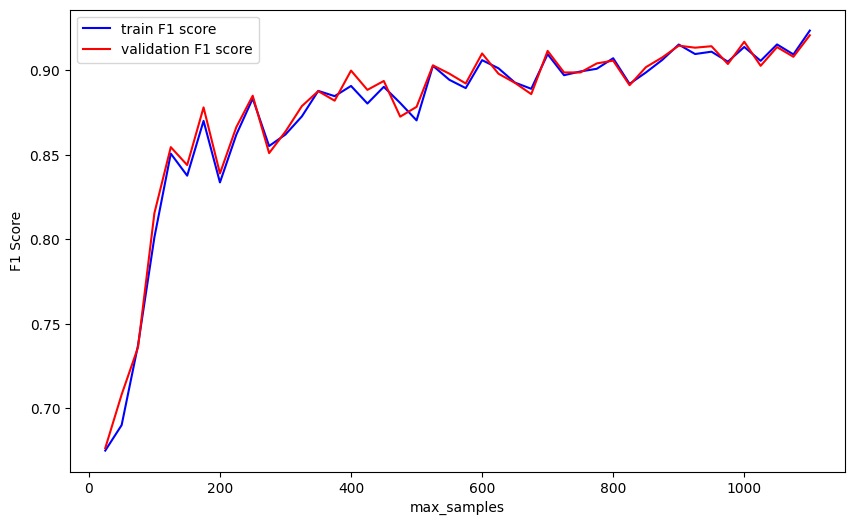

In [17]:
test_range = np.linspace(25,1100,44).astype("int")
print(test_range)
param_vals,train_BA_score,val_BA_score = test_hyperparam("max_samples", test_range, x_train,y_train,x_valid,y_valid)

In [18]:
# lets proceed with 800 samples for the Random Forest Classifier 
def rf(xs, y, n_estimators=4, max_samples=800,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

[1 2 3 4 5 6]


/Users/austinpaxton/Documents/dev/take_home_coding/validate_health/venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/austinpaxton/Documents/dev/take_home_coding/validate_health/venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/austinpaxton/Documents/dev/take_home_coding/validate_health/venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


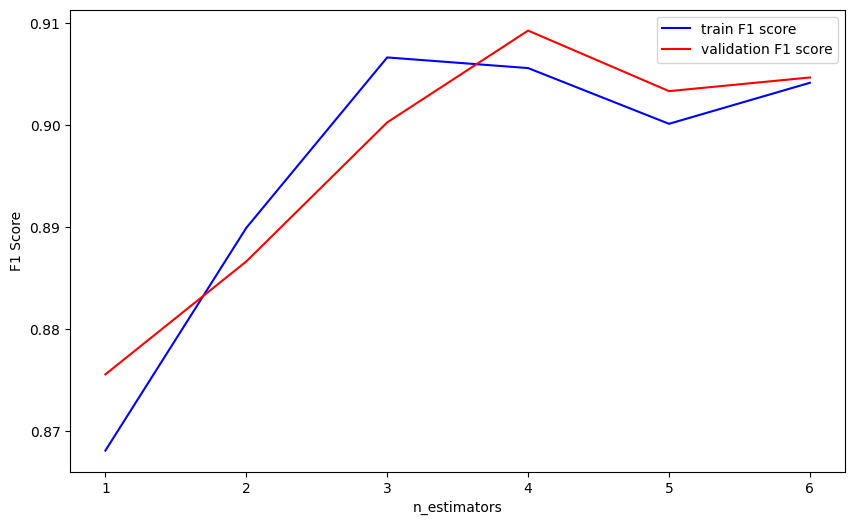

In [19]:
# lets adjust number of estimtors and see if we can improve balanced accuracy score
test_range = np.linspace(1,6,6).astype("int")
print(test_range)
param_vals,train_BA_score,val_BA_score = test_hyperparam("n_estimators", test_range, x_train,y_train,x_valid,y_valid)

In [20]:
# lets proceed with 5 estimators
def rf(xs, y, n_estimators=5, max_samples=800,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

## Train Final Model
* hyperparameters are tuned and now it is time to train our model on the full training set (including validation) and test on test set

In [21]:
full_train_idx = list(range(len(train)))
test_idx = list(range(len(train), len(train) + len(test)))

# Concatenate train and test dataframes for use in TabularPandas
full_data = pd.concat([train, test]).reset_index(drop=True)

# Define splits for TabularPandas, keeping test data completely separate
splits = (full_train_idx, test_idx)


In [22]:
# load training and test data into tabular pandas object
procs = [Categorify]
tb = TabularPandas(full_data, procs, cat_names=cat, cont_names=cont, y_names="churn_reason_code", splits=splits)

In [23]:
x_train = tb.train.xs
y_train = tb.train.y
x_test = tb.valid.xs
y_test = tb.valid.y


In [24]:
m = rf(x_train,y_train)

def display_metrics(m, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    print(f"Train F1 score: {calc_f1_score(m,x_train,y_train)}")
    print(f"Test F1 score: {calc_f1_score(m,x_test,y_test)}")
    print(f"Train Data Predictive Accuracy Score: {accuracy_score(y_train, m.predict(x_train))}")
    print(f"Test Data Predictive Accuracy Score: {accuracy_score(y_test, m.predict(x_test))}")

display_metrics(m)

Train F1 score: 0.8991904327551737
Test F1 score: 0.9021562053744839
Train Data Predictive Accuracy Score: 0.9065340018802883
Test Data Predictive Accuracy Score: 0.908566355969818


In [25]:
print(full_data)

       Sex  Birth Year  Assignment Step Flag  Count of Primary Care Services  \
0        2        1935                     1                               3   
1        1        1925                     1                               4   
2        2        1930                     1                               6   
3        1        1942                     1                               1   
4        1        1942                     1                               3   
...    ...         ...                   ...                             ...   
15012    2        1926                     1                               1   
15013    1        1939                     1                               4   
15014    2        1941                     2                               4   
15015    2        1936                     1                               1   
15016    2        1946                     1                               1   

      churn_reason_code   age  is_dead 

## Analyze Importance of Factors

<Axes: ylabel='cols'>

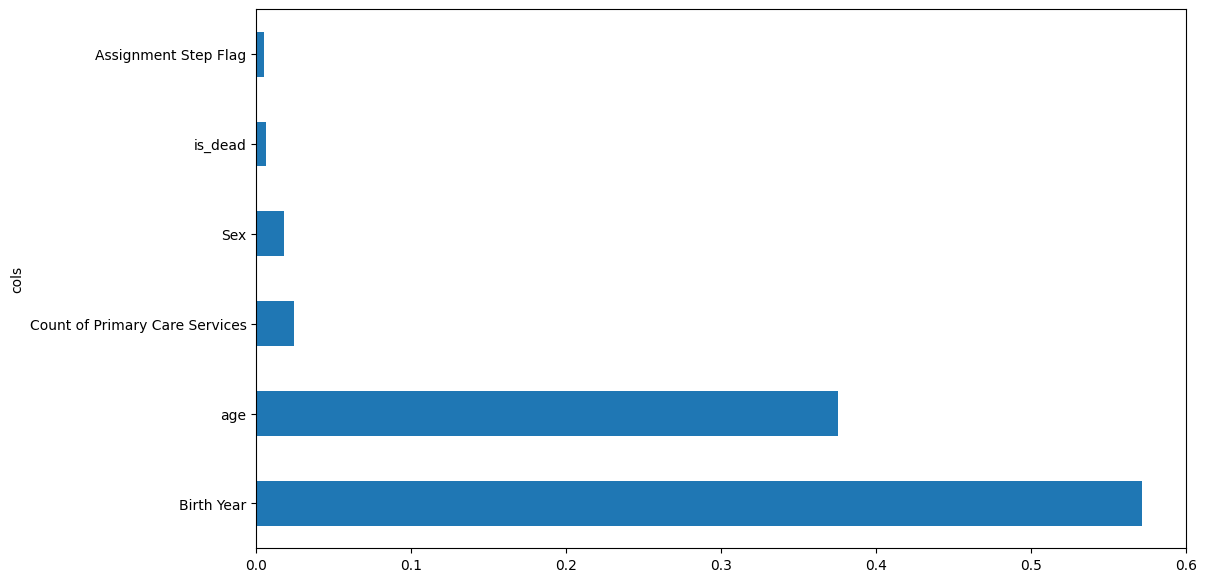

In [26]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

fi = rf_feat_importance(m, x_train)
plot_fi(fi)

In [27]:
# lets remove birth year and see if it has a difference

def remove_feature(drop_col_name,x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    xr_train = x_train.drop(columns=drop_col_name)
    xr_test = x_test.drop(columns=drop_col_name)
    m = rf(xr_train,y_train)
    print(len(xr_test))
    print(len(y_test))
    display_metrics(m, xr_train, y_train, xr_test, y_test)
    return m

In [28]:
m_ = remove_feature("Birth Year")

# accuracy severly decreases after removing most important varaible as expected 


2253
2253
Train F1 score: 0.5858211663941191
Test F1 score: 0.5701636600072261
Train Data Predictive Accuracy Score: 0.6167345659667816
Test Data Predictive Accuracy Score: 0.60497114957834


In [29]:

m_ =remove_feature("is_dead")
# similar accuracy as before

2253
2253
Train F1 score: 0.8821767356907717
Test F1 score: 0.8825488416289134
Train Data Predictive Accuracy Score: 0.8892196803509872
Test Data Predictive Accuracy Score: 0.8890368397691967


In [30]:

m_ =remove_feature("Assignment Step Flag")
# similar accuracy as before

2253
2253
Train F1 score: 0.9102739024799944
Test F1 score: 0.9100373571848347
Train Data Predictive Accuracy Score: 0.9178157317455343
Test Data Predictive Accuracy Score: 0.9169995561473591


In [31]:

m_ =remove_feature("age")
# age drastically reduces accuracy 

2253
2253
Train F1 score: 0.6916847363594162
Test F1 score: 0.6821829263038616
Train Data Predictive Accuracy Score: 0.7079285490441868
Test Data Predictive Accuracy Score: 0.698624056813138


# Analyze Feature Importances per category by converting problem from MultiClass to Binary 

In [38]:
# Dictionary to store feature importances for each churn reason
feature_importances = {}
unique_churn_reasons = [0,1,2,3,4,5]

for reason in unique_churn_reasons:
    # Create a binary target column for the specific churn reason
    y_train_bin = (y_train == reason).astype(int)
    # Initialize and train the Random Forest model
    model = rf(x_train,y_train_bin)

    fi = model.feature_importances_

    feature_importances[reason] = fi


1
1
1
1
1
0


In [54]:
# map codes back to symbols:
feature_importances = {choices[key]: value for key,value in feature_importances.items()}
print(fi)


x_train.columns

{'DD': array([0.07311198, 0.0186446 , 0.03446799, 0.27716683, 0.22984102,
       0.36676758]), 'IM': array([0.0058522 , 0.00832664, 0.00207318, 0.55283745, 0.02240088,
       0.40850965]), 'AB': array([0.08623684, 0.00161134, 0.        , 0.23821868, 0.13199205,
       0.54194108]), 'MH': array([0.02188829, 0.01376353, 0.00653579, 0.54704166, 0.03487495,
       0.37589577]), 'NR': array([0.        , 0.        , 0.        , 0.49540754, 0.35285043,
       0.15174204]), 'OI': array([0., 0., 0., 0., 0., 0.])}


Index(['Sex', 'Assignment Step Flag', 'is_dead', 'Birth Year',
       'Count of Primary Care Services', 'age'],
      dtype='object')

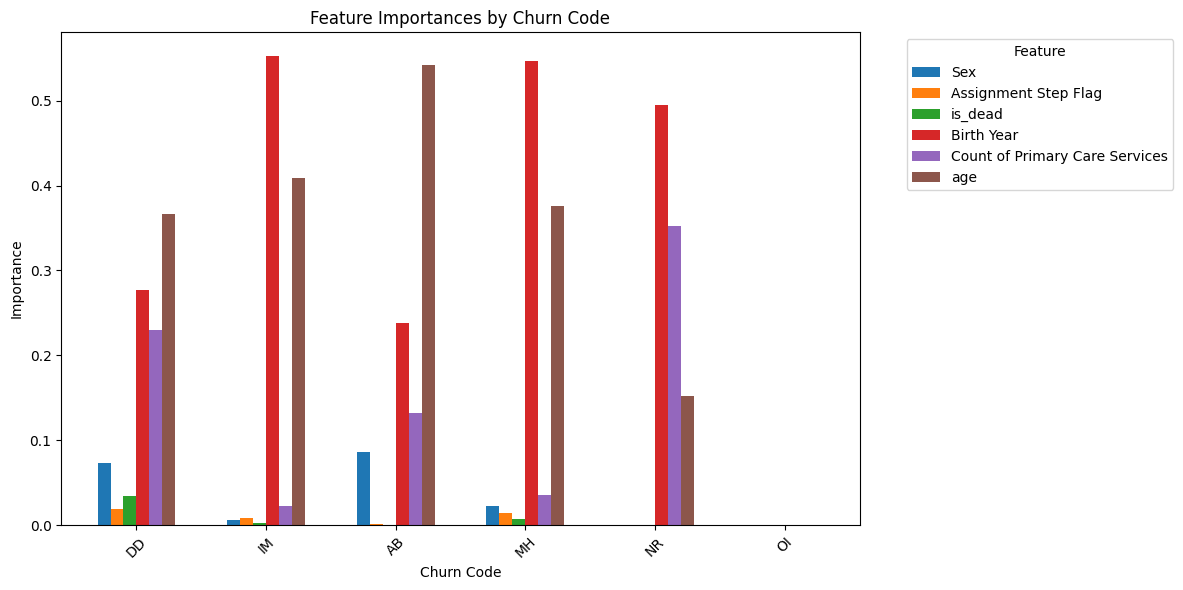

In [60]:
features = x_train.columns

# Number of features
n_features = len(features)

# Number of codes
codes = list(feature_importances.keys())
n_codes = len(codes)

# Position of bars on x-axis
ind = np.arange(n_codes)

# Width of each bar
width = 0.1

fig, ax = plt.subplots(figsize=(12, 6))

for i, feature in enumerate(features):
    # Extract the feature importance for each code
    importances = [feature_importances[code][i] for code in codes]
    # Plotting each set of feature importances
    ax.bar(ind + i*width, importances, width, label=feature)

# Formatting and labels
ax.set_xlabel('Churn Code')
ax.set_ylabel('Importance')
ax.set_title('Feature Importances by Churn Code')
ax.set_xticks(ind + width * (n_features - 1) / 2)  # Center the labels between the sets of bars
ax.set_xticklabels(codes)
ax.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()